# État de l'Art
# VGG16, InceptionV3, MobileNetV2

---

## Mise en place

Intégrer le système de Google pour travailler sur le Drive

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Télécharger les données à traiter dans le répertoire courant.

In [0]:
import urllib.request
import tarfile

url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
file_name = "images.tar"

res = urllib.request.urlretrieve(url, file_name)
with tarfile.open(file_name) as dogs_tar:
  dogs_tar.extractall()

Organiser séparer les données d'entrainement, de validation et de généralisation en différents répertoires. 

On peut charger l'ensemble de la base d'images ou se limiter aux n catégories ayant le plus d'images pour assurer un apprentissage plus optimal

In [0]:
#@title Nombre de catégories à charger

n_categories = 120 #@param {type:"slider", min:0, max:120, step:20}

!cp drive/My\ Drive/Projets\ Formation/Projet\ 7/utils.py .
from utils import organize_data

organize_data(n_categories=n_categories)

!rm images.tar
!rm -R Images

TRAIN SIZE:  12345
VALID SIZE:  4111
TEST SIZE:  4124


Charger les librairies et paramètres utilisés dans le reste du projet

In [0]:
import os
import re
import shutil
import pickle
import numpy as np
from utils import vgg16_preprocess_input, create_generators, learning_curves

import tensorflow as tf
from keras import layers, models
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG16, InceptionV3, MobileNetV2
# !pip install tensorboardcolab
# from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

import matplotlib as mpl
mpl.style.use('default')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Using TensorFlow backend.


## Modèle n°1: VGG16

### Images brutes

Définition de générateurs qui serviront directement de source pour nos images d'apprentissage, de validation et de test
- Chargement et pré-traitement des images (redimensionner, rescale). 
- Attribution des étiquettes cibles
- Séparation du jeu de données: apprentissage, validation et test

In [0]:
train_generator, valid_generator, test_generator =\
  create_generators(
    base_dir = 'data', 
    batch_size = 128, 
    side_length = 224, 
    preprocess_input = vgg16_preprocess_input
)

image_shape = train_generator.image_shape
batch_size = train_generator.batch_size
n_classes = train_generator.num_classes

Found 12345 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.
Found 4124 images belonging to 120 classes.


- Charger la base convolutive pré-entrainée de notre modèle (VGG16)
- Ne pas garder le classifieur attaché (car entrainé pour une autre tâche, avec d'autres cibles)
- Ajuster la dimension d'entrée des images

In [0]:
vgg16_base = VGG16(include_top = False, 
                   weights = 'imagenet', 
                   input_shape = image_shape)

vgg16_base.summary()

58892288/58889256 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool

- Ajout d'un classifieur adapté à notre tâche, avec 60 potentielles classes cibles
- Définir la configuration d'entrainement de notre modèle: optimisateur et taux d'apprentissage, fonction de coût et mesures de performance

In [0]:
model = models.Sequential()
model.add(vgg16_base)
model.add(layers.Flatten())
model.add(layers.Dense(2048, activation = 'relu'))
model.add(layers.Dense(n_classes, activation = 'softmax'))

vgg16_base.trainable = False

In [0]:
model.compile(optimizer = Adam(lr=1e-4), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              51382272  
_________________________________________________________________
dense_2 (Dense)              (None, 120)               245880    
Total params: 66,342,840
Trainable params: 51,628,152
Non-trainable params: 14,714,688
_________________________________________________________________


- Entrainement du modèle sur plusieurs passes
- Évaluation continue de la généralisation du modèle avec jeu de validation

In [0]:
# tbc = TensorBoardColab(graph_path="./vgg_graph_1")

callbacks = [
    EarlyStopping(patience = 5, min_delta = 0.01),
    ModelCheckpoint('vgg16_simple.h5', save_best_only = True),
    # TensorBoardColabCallback(tbc),
]

history = model.fit_generator(
    generator = train_generator, 
    steps_per_epoch = np.ceil(train_generator.n/batch_size),  
    validation_data = valid_generator, 
    validation_steps = np.ceil(valid_generator.n/batch_size),
    epochs = 100, verbose = 1, callbacks = callbacks)

Epoch 1/100
97/97 [==============================] - 162s 2s/step - loss: 3.7920 - acc: 0.1673 - val_loss: 3.0201 - val_acc: 0.2841
Epoch 2/100
97/97 [==============================] - 143s 1s/step - loss: 1.6369 - acc: 0.6356 - val_loss: 2.5689 - val_acc: 0.3559
Epoch 3/100
97/97 [==============================] - 143s 1s/step - loss: 0.7528 - acc: 0.8812 - val_loss: 2.4285 - val_acc: 0.3826
Epoch 4/100
97/97 [==============================] - 143s 1s/step - loss: 0.3456 - acc: 0.9701 - val_loss: 2.3675 - val_acc: 0.3882
Epoch 5/100
97/97 [==============================] - 143s 1s/step - loss: 0.1696 - acc: 0.9946 - val_loss: 2.3225 - val_acc: 0.4077
Epoch 6/100
97/97 [==============================] - 143s 1s/step - loss: 0.0958 - acc: 0.9977 - val_loss: 2.2860 - val_acc: 0.4128
Epoch 7/100
97/97 [==============================] - 143s 1s/step - loss: 0.0653 - acc: 0.9982 - val_loss: 2.2801 - val_acc: 0.4157
Epoch 8/100
97/97 [==============================] - 143s 1s/step - loss: 0.

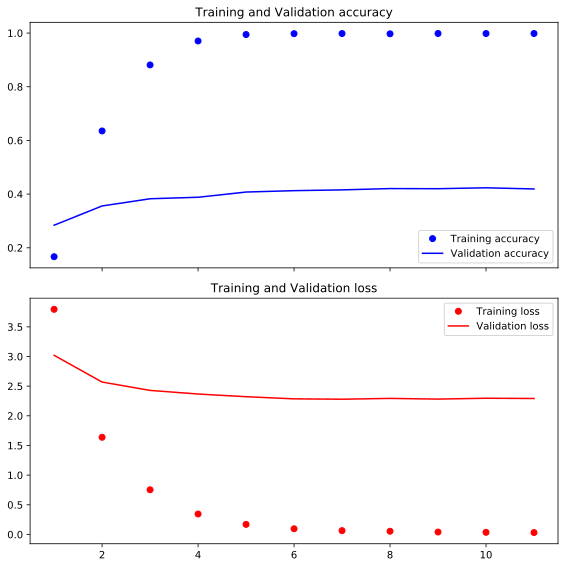

In [0]:
learning_curves(history)

Commentaire: modèle fort suceptible au sur-apprentissage, avec, par conséquent, une très mauvaise généralisation.

In [0]:
test_loss, test_acc =\
  model.evaluate_generator(test_generator, 
                           steps = test_generator.n)

print('Test accuracy: ', round(test_acc*100, 2))

Test accuracy:  41.25


### Méthodes de régularisation: Data Augmentation et Dropout

Ajouter de faibles transformations sur les images d'apprentissage (rotation, distortions, retournements…) pour étoffer notre jeu d'apprentissage, pour permettre une meilleure généralisation de notre modèle en luttant contre le sur-apprentissage.

In [0]:
train_generator, valid_generator, test_generator =\
  create_generators(
    base_dir = 'data', 
    batch_size = 128, 
    side_length = 224, 
    augmentation = True,
    preprocess_input = vgg16_preprocess_input
)

image_shape = train_generator.image_shape
batch_size = train_generator.batch_size
n_classes = train_generator.num_classes

Found 12345 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.
Found 4124 images belonging to 120 classes.


- Charger une nouvelle base convolutive pré-entrainée de notre modèle (VGG16)
- Ajout couche Dropout

In [0]:
vgg16_base = VGG16(include_top=False, 
                   weights='imagenet', 
                   input_shape=image_shape)

vgg_model = models.Sequential()
vgg_model.add(vgg16_base)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dense(2048, activation='relu'))
vgg_model.add(layers.Dropout(0.5))
vgg_model.add(layers.Dense(n_classes, activation='softmax'))

vgg16_base.trainable = False

vgg_model.compile(optimizer=Adam(lr=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['acc'])
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              51382272  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               245880    
Total params: 66,342,840
Trainable params: 51,628,152
Non-trainable params: 14,714,688
_________________________________________________________________


Entrainer et évaluer

In [0]:
###############
# 182 MINUTES #
###############

# tbc = TensorBoardColab(graph_path="./vgg_graph_2")

callbacks = [
    EarlyStopping(patience=5, min_delta=0.01),
    ModelCheckpoint('vgg16_regularized.h5', save_best_only=True),
    # TensorBoardColabCallback(tbc),
]

history = vgg_model.fit_generator(
    generator = train_generator, 
    steps_per_epoch = np.ceil(train_generator.n/batch_size),  
    validation_data = valid_generator, 
    validation_steps = np.ceil(valid_generator.n/batch_size),
    epochs = 100, verbose = 1, callbacks = callbacks)

Epoch 1/100
97/97 [==============================] - 266s 3s/step - loss: 4.7381 - acc: 0.0288 - val_loss: 4.1582 - val_acc: 0.1068
Epoch 2/100
97/97 [==============================] - 231s 2s/step - loss: 4.2590 - acc: 0.0761 - val_loss: 3.5799 - val_acc: 0.1997
Epoch 3/100
97/97 [==============================] - 235s 2s/step - loss: 3.9179 - acc: 0.1198 - val_loss: 3.2000 - val_acc: 0.2559
Epoch 4/100
97/97 [==============================] - 235s 2s/step - loss: 3.6352 - acc: 0.1597 - val_loss: 2.9195 - val_acc: 0.3106
Epoch 5/100
97/97 [==============================] - 235s 2s/step - loss: 3.4297 - acc: 0.1966 - val_loss: 2.7231 - val_acc: 0.3379
Epoch 6/100
97/97 [==============================] - 237s 2s/step - loss: 3.2602 - acc: 0.2209 - val_loss: 2.5741 - val_acc: 0.3637
Epoch 7/100
97/97 [==============================] - 240s 2s/step - loss: 3.1341 - acc: 0.2384 - val_loss: 2.4820 - val_acc: 0.3719
Epoch 8/100
97/97 [==============================] - 239s 2s/step - loss: 2.

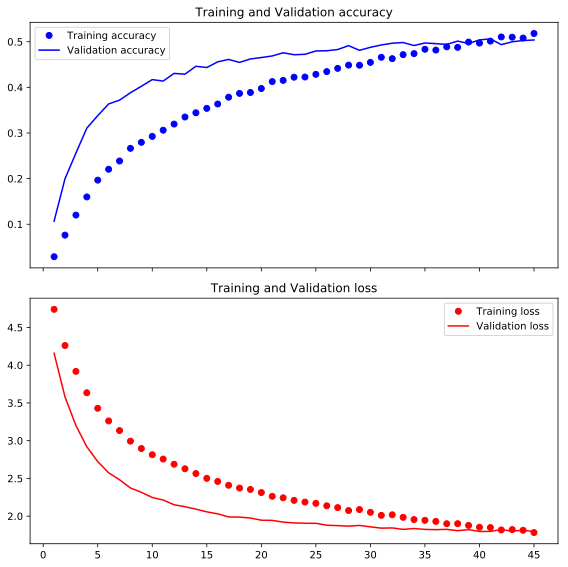

In [0]:
learning_curves(history, mult_ticks=5)

Commentaire: pas de sur-apprentissage cette fois. Un taux de généralisation légèrement plus important, qui évolue avec chaque epoch d'apprentissage.

In [0]:
test_loss, test_acc =\
  vgg_model.evaluate_generator(test_generator, 
                               steps=test_generator.n)

print('\nTest accuracy: ', round(test_acc*100, 2))


Test accuracy:  49.25


In [0]:
!du --block-size=M vgg16_regularized.h5
!cp vgg16_regularized.h5 drive/My\ Drive/Projets\ Formation/Projet\ 7/models

648M	vgg16_regularized.h5


### Fine-tuning

Modifier modèle précédemment entrainé: rendre les couches supérieures entrainables

In [0]:
!cp drive/My\ Drive/Projets\ Formation/Projet\ 7/models/vgg16_regularized.h5 .
vgg_model = models.load_model('vgg16_regularized.h5')

train_generator, valid_generator, test_generator =\
  create_generators(
    base_dir = 'data', 
    batch_size = 128, 
    side_length = 224, 
    augmentation = True,
    preprocess_input = vgg16_preprocess_input
)

image_shape = train_generator.image_shape
batch_size = train_generator.batch_size
n_classes = train_generator.num_classes

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Found 12345 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.
Found 4124 images belonging to 120 classes.


In [0]:
vgg_model.layers[0].trainable = True
set_trainable = False

for layer in vgg_model.layers[0].layers:
  # if layer.name == 'block3_conv1':
  #  set_trainable = True
  #  print("*"*20)
  layer.trainable = True
  
  print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
********************
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [0]:
vgg_model.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', 
                  metrics=['acc'])
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              51382272  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               245880    
Total params: 66,342,840
Trainable params: 66,342,840
Non-trainable params: 0
_________________________________________________________________


Entrainer et évaluer

In [0]:
##############
# 92 MINUTES #
##############

callbacks = [
    EarlyStopping(patience=5, min_delta=0.005),
    ModelCheckpoint('vgg16_tuned.h5', save_best_only=True),
]

history = vgg_model.fit_generator(
    generator = train_generator, 
    steps_per_epoch = np.ceil(train_generator.n/batch_size),  
    validation_data = valid_generator, 
    validation_steps = np.ceil(valid_generator.n/batch_size),
    epochs=100, verbose=1, callbacks=callbacks)

Epoch 1/100
97/97 [==============================] - 460s 5s/step - loss: 1.7958 - acc: 0.5030 - val_loss: 1.0302 - val_acc: 0.7069
Epoch 2/100
97/97 [==============================] - 418s 4s/step - loss: 1.5810 - acc: 0.5514 - val_loss: 0.9677 - val_acc: 0.7244
Epoch 3/100
97/97 [==============================] - 424s 4s/step - loss: 1.5326 - acc: 0.5657 - val_loss: 0.9364 - val_acc: 0.7244
Epoch 4/100
97/97 [==============================] - 418s 4s/step - loss: 1.4506 - acc: 0.5843 - val_loss: 0.9529 - val_acc: 0.7261
Epoch 5/100
97/97 [==============================] - 420s 4s/step - loss: 1.4003 - acc: 0.5949 - val_loss: 0.9257 - val_acc: 0.7307
Epoch 6/100
97/97 [==============================] - 417s 4s/step - loss: 1.3248 - acc: 0.6144 - val_loss: 0.8981 - val_acc: 0.7412
Epoch 7/100
97/97 [==============================] - 416s 4s/step - loss: 1.3028 - acc: 0.6237 - val_loss: 0.8883 - val_acc: 0.7439
Epoch 8/100
97/97 [==============================] - 416s 4s/step - loss: 1.

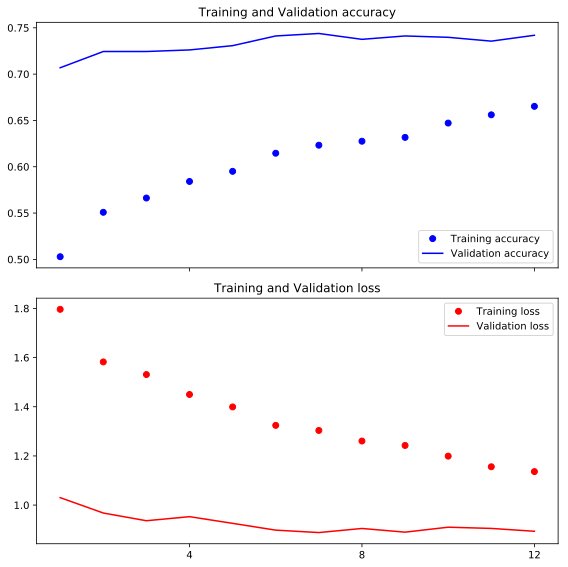

In [0]:
learning_curves(history, mult_ticks=4)

In [0]:
vgg_model = models.load_model('vgg16_tuned.h5')

test_loss, test_acc =\
  vgg_model.evaluate_generator(test_generator, 
                               steps=test_generator.n, 
                               verbose=0)

print('\nTest accuracy: ', round(test_acc*100, 2))


Test accuracy:  72.58


Sauvegardons le dictionnaire qui permet d'encoder chaque classe en un entier.

In [0]:
with open('class_traductor_120.pkl', 'wb') as f:
    pickle.dump(train_generator.class_indices, f)

!cp class_traductor_120.pkl drive/My\ Drive/Projets\ Formation/Projet\ 7/

Taille du modèle

Sauvegardons le modèle sur notre espace de travail Drive

In [0]:
!du --block-size=M vgg16_tuned.h5
!cp vgg16_tuned.h5 drive/My\ Drive/Projets\ Formation/Projet\ 7/models

760M	vgg16_tuned.h5


## Modèle n°2: InceptionV3

### Pré-entrainement du classifieur

In [0]:
train_generator, valid_generator, test_generator =\
  create_generators(
    base_dir = 'data', 
    batch_size = 128, 
    side_length = 299, 
    augmentation = True,
    preprocess_input = tf.keras.applications.inception_v3.preprocess_input
)

image_shape = train_generator.image_shape
batch_size = train_generator.batch_size
n_classes = train_generator.num_classes

Found 12345 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.
Found 4124 images belonging to 120 classes.


In [0]:
inceptionv3_base = InceptionV3(weights = 'imagenet', 
                               include_top = False,
                               input_shape = image_shape)
inceptionv3_base.trainable = False

inception_model = models.Sequential()
inception_model.add(inceptionv3_base)
inception_model.add(layers.GlobalAveragePooling2D())
inception_model.add(layers.Dense(2048, activation='relu'))
inception_model.add(layers.Dropout(0.5))
inception_model.add(layers.Dense(n_classes, activation='softmax'))

inception_model.compile(optimizer=Adam(lr=1e-4), 
                        loss='categorical_crossentropy', 
                        metrics=['acc'])

inception_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               245880    
Total params: 26,245,016
Trainable params: 4,442,232
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
###############
# 110 MINUTES #
###############

# tbc = TensorBoardColab(graph_path="./inception_graph_1")

callbacks = [
    EarlyStopping(patience=5, min_delta=0.01),
    ModelCheckpoint('inceptionv3_regularized.h5', save_best_only=True),
    # TensorBoardColabCallback(tbc),
]

history = inception_model.fit_generator(
    generator = train_generator, 
    steps_per_epoch = np.ceil(train_generator.n/batch_size),  
    validation_data = valid_generator, 
    validation_steps = np.ceil(valid_generator.n/batch_size),
    epochs = 100, verbose = 1, callbacks = callbacks)

Epoch 1/100
97/97 [==============================] - 426s 4s/step - loss: 3.8607 - acc: 0.2585 - val_loss: 1.8952 - val_acc: 0.8144
Epoch 2/100
97/97 [==============================] - 384s 4s/step - loss: 2.0788 - acc: 0.5694 - val_loss: 0.7033 - val_acc: 0.8577
Epoch 3/100
97/97 [==============================] - 386s 4s/step - loss: 1.4632 - acc: 0.6473 - val_loss: 0.4918 - val_acc: 0.8781
Epoch 4/100
97/97 [==============================] - 405s 4s/step - loss: 1.2701 - acc: 0.6761 - val_loss: 0.4195 - val_acc: 0.8864
Epoch 5/100
97/97 [==============================] - 409s 4s/step - loss: 1.1581 - acc: 0.6963 - val_loss: 0.3867 - val_acc: 0.8927
Epoch 6/100
97/97 [==============================] - 387s 4s/step - loss: 1.0934 - acc: 0.7053 - val_loss: 0.3714 - val_acc: 0.8857
Epoch 7/100
97/97 [==============================] - 382s 4s/step - loss: 1.0538 - acc: 0.7131 - val_loss: 0.3662 - val_acc: 0.8840
Epoch 8/100
97/97 [==============================] - 376s 4s/step - loss: 1.

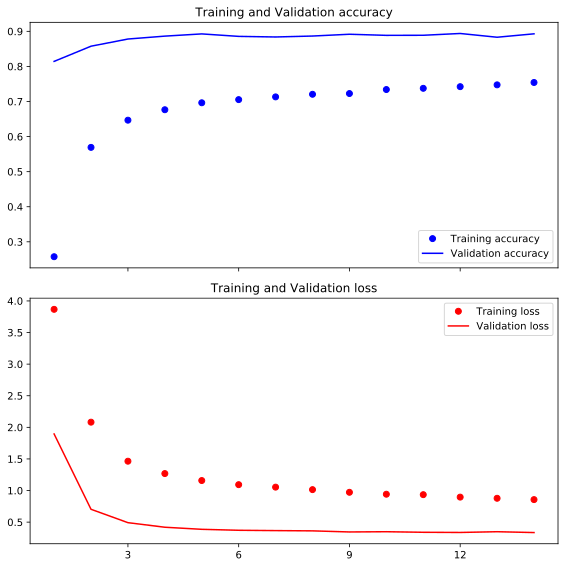

In [0]:
learning_curves(history, mult_ticks=3)

In [0]:
inception_model = models.load_model('inceptionv3_regularized.h5')

test_loss, test_acc =\
  inception_model.evaluate_generator(test_generator, 
                                     steps=test_generator.n, 
                                     verbose=0)

print('\nTest accuracy: ', round(test_acc*100, 2))

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '



Test accuracy:  89.6


In [0]:
!du --block-size=M inceptionv3_regularized.h5
!cp inceptionv3_regularized.h5 drive/My\ Drive/Projets\ Formation/Projet\ 7/models

135M	inceptionv3_regularized.h5


### Fine-tuning du modèle entier

Prendre image là dedans
https://sefiks.com/2017/12/10/transfer-learning-in-keras-using-inception-v3/

On fine-tune les deux derniers modules d'inception (à partir de la 9e couche de concatenation) 

In [0]:
!cp drive/My\ Drive/Projets\ Formation/Projet\ 7/models/inceptionv3_regularized.h5 .
inception_model = models.load_model('inceptionv3_regularized.h5')

train_generator, valid_generator, test_generator =\
  create_generators(
    base_dir = 'data', 
    batch_size = 128, 
    side_length = 299, 
    augmentation = True,
    preprocess_input = tf.keras.applications.inception_v3.preprocess_input
)

image_shape = train_generator.image_shape
batch_size = train_generator.batch_size
n_classes = train_generator.num_classes

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Found 12345 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.
Found 4124 images belonging to 120 classes.


In [0]:
inception_model.layers[0].trainable = True
set_trainable = False

for layer in inception_model.layers[0].layers:
  layer.trainable = set_trainable
  if layer.name == 'mixed8':
    set_trainable = True
  

# for layer in inception_model.layers[0].layers:
#   print(layer.name, layer.trainable)

In [0]:
inception_model.compile(optimizer=Adam(lr=1e-5),
                        loss='categorical_crossentropy', 
                        metrics=['acc'])
inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               245880    
Total params: 26,245,016
Trainable params: 15,557,112
Non-trainable params: 10,687,904
_________________________________________________________________


In [0]:
##############
# 54 MINUTES #
##############

callbacks = [
    EarlyStopping(patience=5, min_delta=0.01),
    ModelCheckpoint('inceptionv3_tuned.h5', save_best_only=True),
]

history = inception_model.fit_generator(
    generator = train_generator, 
    steps_per_epoch = np.ceil(train_generator.n/batch_size),  
    validation_data = valid_generator, 
    validation_steps = np.ceil(valid_generator.n/batch_size),
    epochs=100, verbose=1, callbacks=callbacks)

Epoch 1/100
97/97 [==============================] - 415s 4s/step - loss: 0.8674 - acc: 0.7518 - val_loss: 0.3966 - val_acc: 0.8755
Epoch 2/100
97/97 [==============================] - 373s 4s/step - loss: 0.7958 - acc: 0.7661 - val_loss: 0.3889 - val_acc: 0.8757
Epoch 3/100
97/97 [==============================] - 382s 4s/step - loss: 0.7400 - acc: 0.7827 - val_loss: 0.3822 - val_acc: 0.8755
Epoch 4/100
97/97 [==============================] - 382s 4s/step - loss: 0.7240 - acc: 0.7838 - val_loss: 0.3802 - val_acc: 0.8808
Epoch 5/100
97/97 [==============================] - 384s 4s/step - loss: 0.6869 - acc: 0.7947 - val_loss: 0.3773 - val_acc: 0.8793
Epoch 6/100
97/97 [==============================] - 383s 4s/step - loss: 0.6610 - acc: 0.8026 - val_loss: 0.3768 - val_acc: 0.8798
Epoch 7/100
97/97 [==============================] - 383s 4s/step - loss: 0.6360 - acc: 0.8079 - val_loss: 0.3745 - val_acc: 0.8786
Epoch 8/100
97/97 [==============================] - 382s 4s/step - loss: 0.

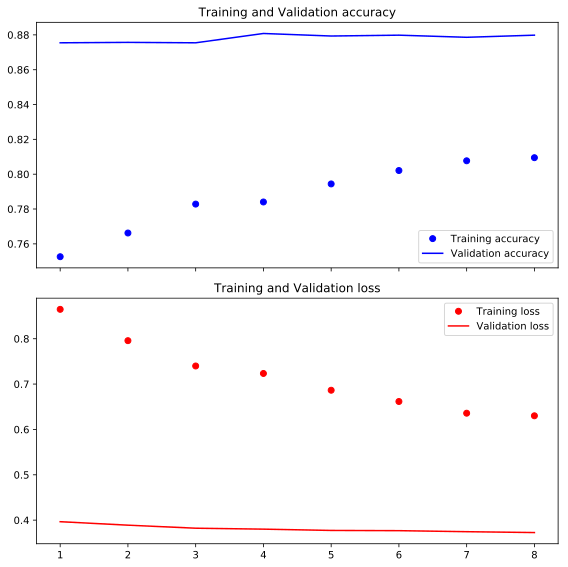

In [0]:
learning_curves(history, mult_ticks=1)

In [0]:
inception_model = models.load_model('inceptionv3_tuned.h5')

test_loss, test_acc =\
  inception_model.evaluate_generator(test_generator, 
                                     steps=test_generator.n, 
                                     verbose=1)

print('\nTest accuracy: ', round(test_acc*100, 2))

4124/4124 [==============================] - 175s 42ms/step

Test accuracy:  88.48


In [0]:
!du --block-size=M inceptionv3_tuned.h5
!cp inceptionv3_tuned.h5 drive/My\ Drive/Projets\ Formation/Projet\ 7/models

220M	inceptionv3_tuned.h5


## Modèle n°3: MobileNetV2

### Pre-train

In [0]:
train_generator, valid_generator, test_generator =\
  create_generators(
    base_dir = 'data', 
    batch_size = 128, 
    side_length = 224, 
    augmentation = False,
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
)

image_shape = train_generator.image_shape
batch_size = train_generator.batch_size
n_classes = train_generator.num_classes

Found 12345 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.
Found 4124 images belonging to 120 classes.


In [0]:
mobilenetV2_base = MobileNetV2(weights = 'imagenet', 
                               include_top = False,
                               input_shape = image_shape)
mobilenetV2_base.trainable = False

mobilenet_model = models.Sequential()
mobilenet_model.add(mobilenetV2_base)
mobilenet_model.add(layers.GlobalAveragePooling2D())
mobilenet_model.add(layers.Dense(512, activation = 'relu'))
mobilenet_model.add(layers.Dropout(0.5))
mobilenet_model.add(layers.Dense(n_classes, activation = 'softmax'))

mobilenet_model.compile(optimizer = Adam(1e-4),  
                        loss = 'categorical_crossentropy', 
                        metrics = ['acc'])

mobilenet_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               61560     
Total params: 2,975,416
Trainable params: 717,432
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
##############
# 38 MINUTES #
##############

# tbc = TensorBoardColab(graph_path="./mobilenet_graph_1")

callbacks = [
    EarlyStopping(patience=5, min_delta=0.01),
    ModelCheckpoint('mobilenetv2_regularized.h5', save_best_only=True),
    # TensorBoardColabCallback(tbc),
]

history = mobilenet_model.fit_generator(
    generator = train_generator, 
    steps_per_epoch = np.ceil(train_generator.n/batch_size),  
    validation_data = valid_generator, 
    validation_steps = np.ceil(valid_generator.n/batch_size),
    epochs = 100, verbose = 1, callbacks = callbacks)

Epoch 1/100
97/97 [==============================] - 95s 975ms/step - loss: 4.6359 - acc: 0.0459 - val_loss: 3.9054 - val_acc: 0.2902
Epoch 2/100
97/97 [==============================] - 81s 836ms/step - loss: 3.7342 - acc: 0.2023 - val_loss: 2.6952 - val_acc: 0.5393
Epoch 3/100
97/97 [==============================] - 81s 836ms/step - loss: 2.8683 - acc: 0.3500 - val_loss: 1.8264 - val_acc: 0.6595
Epoch 4/100
97/97 [==============================] - 81s 832ms/step - loss: 2.2631 - acc: 0.4586 - val_loss: 1.3874 - val_acc: 0.6989
Epoch 5/100
97/97 [==============================] - 81s 838ms/step - loss: 1.9401 - acc: 0.5134 - val_loss: 1.1659 - val_acc: 0.7271
Epoch 6/100
97/97 [==============================] - 81s 839ms/step - loss: 1.7011 - acc: 0.5581 - val_loss: 1.0316 - val_acc: 0.7336
Epoch 7/100
97/97 [==============================] - 81s 831ms/step - loss: 1.5523 - acc: 0.5869 - val_loss: 0.9465 - val_acc: 0.7480
Epoch 8/100
97/97 [==============================] - 81s 833ms

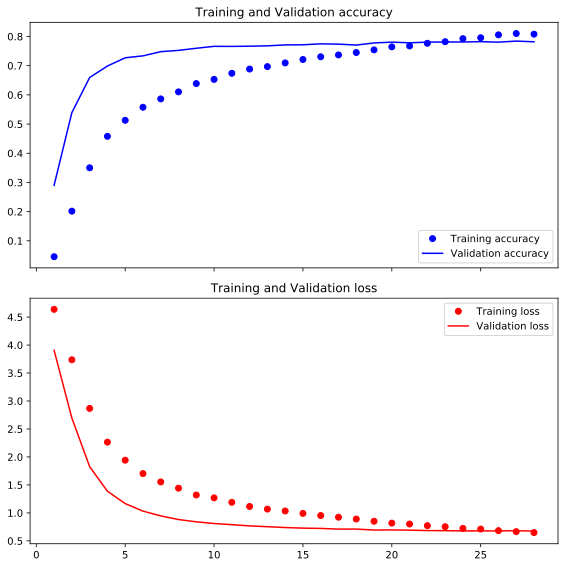

In [0]:
learning_curves(history, mult_ticks=5)

In [0]:
mobilenet_model = models.load_model('mobilenetv2_regularized.h5')

test_loss, test_acc =\
  mobilenet_model.evaluate_generator(test_generator, 
                                     steps=test_generator.n, 
                                     verbose=1)

print('\nTest accuracy: ', round(test_acc*100, 2))

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


4124/4124 [==============================] - 75s 18ms/step

Test accuracy:  78.06


In [0]:
!du --block-size=M mobilenetv2_regularized.h5
!cp mobilenetv2_regularized.h5 drive/My\ Drive/Projets\ Formation/Projet\ 7/models

18M	mobilenetv2_regularized.h5


### Fine-tuning

In [0]:
train_generator, valid_generator, test_generator =\
  create_generators(
    base_dir = 'data', 
    batch_size = 128, 
    side_length = 224, 
    augmentation = False,
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
)

image_shape = train_generator.image_shape
batch_size = train_generator.batch_size
n_classes = train_generator.num_classes

Found 12345 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.
Found 4124 images belonging to 120 classes.


In [0]:
!cp drive/My\ Drive/Projets\ Formation/Projet\ 7/models/mobilenetv2_regularized.h5 .
mobilenet_model = models.load_model('mobilenetv2_regularized.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [0]:
# mobilenet_model.layers[0].summary()

mobilenet_model.layers[0].trainable = True
set_trainable = False

for layer in mobilenet_model.layers[0].layers:
  if layer.name == 'block_10_expand':
    set_trainable = True
  layer.trainable = set_trainable
  

# for layer in mobilenet_model.layers[0].layers:
#   print(layer.name, layer.trainable)

In [0]:
mobilenet_model.compile(optimizer=Adam(lr=1e-5),
                        loss='categorical_crossentropy', 
                        metrics=['acc'])
mobilenet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               61560     
Total params: 2,975,416
Trainable params: 2,701,944
Non-trainable params: 273,472
_________________________________________________________________


In [0]:
##############
# 13 MINUTES #
##############

callbacks = [
    EarlyStopping(patience=5, min_delta=0.01),
    ModelCheckpoint('mobilenetv2_tuned.h5', save_best_only=True),
]

history = mobilenet_model.fit_generator(
    generator = train_generator, 
    steps_per_epoch = np.ceil(train_generator.n/batch_size),  
    validation_data = valid_generator, 
    validation_steps = np.ceil(valid_generator.n/batch_size),
    epochs=100, verbose=1, callbacks=callbacks)

Epoch 1/100
97/97 [==============================] - 103s 1s/step - loss: 0.8379 - acc: 0.7553 - val_loss: 0.5022 - val_acc: 0.8655
Epoch 2/100
97/97 [==============================] - 84s 867ms/step - loss: 0.7522 - acc: 0.7775 - val_loss: 0.4867 - val_acc: 0.8667
Epoch 3/100
97/97 [==============================] - 85s 880ms/step - loss: 0.6859 - acc: 0.7966 - val_loss: 0.4782 - val_acc: 0.8667
Epoch 4/100
97/97 [==============================] - 85s 876ms/step - loss: 0.6493 - acc: 0.8025 - val_loss: 0.4731 - val_acc: 0.8635
Epoch 5/100
97/97 [==============================] - 85s 875ms/step - loss: 0.6120 - acc: 0.8158 - val_loss: 0.4675 - val_acc: 0.8638
Epoch 6/100
97/97 [==============================] - 85s 875ms/step - loss: 0.5757 - acc: 0.8257 - val_loss: 0.4642 - val_acc: 0.8648
Epoch 7/100
97/97 [==============================] - 85s 877ms/step - loss: 0.5356 - acc: 0.8390 - val_loss: 0.4610 - val_acc: 0.8640
Epoch 8/100
97/97 [==============================] - 84s 868ms/s

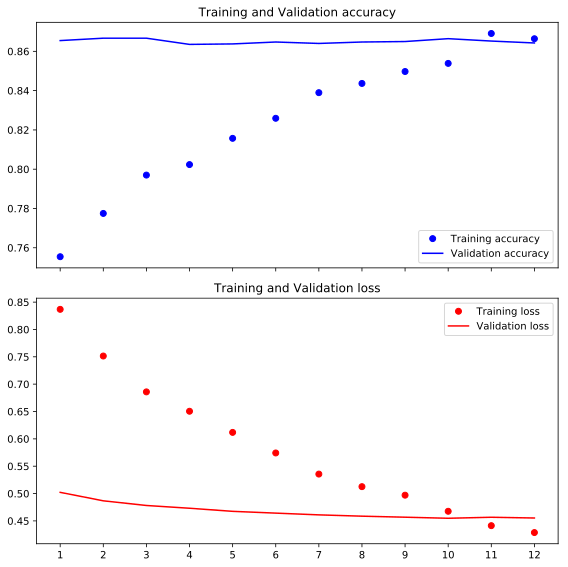

In [0]:
learning_curves(history, mult_ticks=1)

In [0]:
mobilenet_model = models.load_model('mobilenetv2_tuned.h5')

test_loss, test_acc =\
  mobilenet_model.evaluate_generator(test_generator, 
                                     steps=test_generator.n, 
                                     verbose=1)

print('\nTest accuracy: ', round(test_acc*100, 2))

4124/4124 [==============================] - 67s 16ms/step

Test accuracy:  84.63


In [0]:
!du --block-size=M mobilenetv2_tuned.h5
!cp mobilenetv2_tuned.h5 drive/My\ Drive/Projets\ Formation/Projet\ 7/models

33M	mobilenetv2_tuned.h5


## Conclusion

- Matrices de confusion
- Tableau comparer taux de généralisation + taille pour chaque modèle

Tout charger

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
!cp drive/My\ Drive/Projets\ Formation/Projet\ 7/plot_confusion_matrix.py .
from plot_confusion_matrix import plot_confusion_matrix

In [0]:
# Test generators
_, _, vgg_generator =\
  create_generators(
    base_dir = 'data', batch_size = 1, side_length = 224,
    preprocess_input = vgg16_preprocess_input
)

_, _, inception_generator =\
  create_generators(
    base_dir = 'data', batch_size = 1, side_length = 299,
    preprocess_input = tf.keras.applications.inception_v3.preprocess_input
)

_, _, mobilenet_generator =\
  create_generators(
    base_dir = 'data', batch_size = 1, side_length = 224,
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
)

raw_generator = ImageDataGenerator().flow_from_directory(
    directory=os.path.join('data', 'test'), 
    class_mode='categorical', 
    batch_size=1, 
    shuffle=False)

# Best models for each architecture
!cp drive/My\ Drive/Projets\ Formation/Projet\ 7/models/vgg16_regularized.h5 .
!cp drive/My\ Drive/Projets\ Formation/Projet\ 7/models/inceptionv3_regularized.h5 .
!cp drive/My\ Drive/Projets\ Formation/Projet\ 7/models/mobilenetv2_tuned.h5 .

vgg_model = models.load_model('vgg16_regularized.h5')
inception_model = models.load_model('inceptionv3_regularized.h5')
mobilenet_model = models.load_model('mobilenetv2_tuned.h5')

- Vrais labels et noms de classes

In [0]:
true_labels = raw_generator.classes
class_names = (list(raw_generator.class_indices.keys()))

- Prédictions par modèle
- Classification report

In [0]:
vgg_probas = vgg_model.predict_generator(vgg_generator, 
                                         steps=vgg_generator.n, 
                                         workers=4, verbose=1)
vgg_predictions = np.argmax(vgg_probas, axis=1)

4124/4124 [==============================] - 127s 31ms/step


In [0]:
print(classification_report(true_labels, vgg_predictions, 
                            target_names=class_names))

In [0]:
inception_probas = inception_model.predict_generator(inception_generator, 
                                                     steps=inception_generator.n, 
                                                     verbose=1)
inception_predictions = np.argmax(inception_probas, axis=1)

4124/4124 [==============================] - 164s 40ms/step


In [0]:
print(classification_report(true_labels, inception_predictions, 
                            target_names=class_names))

                                precision    recall  f1-score   support

                 Affenpinscher       1.00      0.97      0.98        30
                  Afghan_Hound       0.98      1.00      0.99        48
           African_Hunting_Dog       1.00      0.94      0.97        34
                      Airedale       0.93      0.98      0.95        41
American_Staffordshire_Terrier       0.71      0.91      0.80        33
                   Appenzeller       0.87      0.67      0.75        30
            Australian_Terrier       0.78      0.92      0.85        39
                       Basenji       1.00      0.90      0.95        42
                        Basset       0.97      0.89      0.93        35
                        Beagle       0.82      0.92      0.87        39
            Bedlington_Terrier       0.95      1.00      0.97        37
          Bernese_Mountain_Dog       0.81      1.00      0.90        43
       Black-And-Tan_Coonhound       0.90      0.88      0.89  